In [ ]:
!pip install wandb

!wandb login 9172fb113e07d174f618e9042047cc5c4adacc0f

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import wandb
import joblib

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

manualSeed = 42
torch.manual_seed(manualSeed)
# Sets the seed for generating random numbers for all devices (CPU and CUDA).
# Ensures that the same random numbers are generated each time the code is run,
# making the results reproducible.

torch.use_deterministic_algorithms(False)
# Enables deterministic algorithms for operations in PyTorch. This means that
# the operations will always produce the same output given the same inputs,
# even on different hardware or different runs.
# It is crucial for reproducibility, particularly when using CUDA.

Using device: cuda


In [ ]:
def load_fashion_mnist(batch_size=128):
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    transform = transforms.Compose([transforms.ToTensor()])

    # Load Fashion MNIST
    # TODO: change to read from local
    train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


In [ ]:
def get_label_subset(train_dataset, num_labels, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility
    indices = []
    num_classes = 10
    examples_per_class = num_labels // num_classes

    for label in range(num_classes):
        label_indices = np.where(np.array(train_dataset.targets) == label)[0]
        np.random.shuffle(label_indices)  # Shuffle the indices
        indices += list(label_indices[:examples_per_class])
    return Subset(train_dataset, indices)


In [ ]:
train_loader, test_loader, train_dataset, test_dataset = load_fashion_mnist()

100%|██████████| 26421880/26421880 [00:04<00:00, 5458857.01it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205157.80it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3736226.35it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21484852.73it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



torch.Size([60000, 28, 28])
torch.Size([1, 28, 28])
9
torch.Size([60000])
(28, 28)


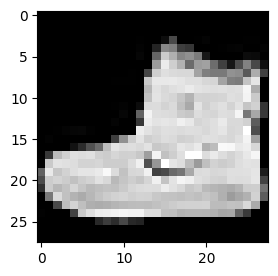

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a 2D array called 'image_array' representing the pixel data

def display_image(image_array):
  fig, ax = plt.subplots(figsize=(3, 3))  # Adjust figure size as needed
  plt.imshow(image_array, cmap='gray', interpolation='nearest')
  plt.show()


# Example usage:
print(train_dataset.data.shape)
print(train_dataset[0][0].shape)
print(train_dataset[0][1])
print(train_dataset.targets.shape)
image_array = train_dataset[0][0].numpy().squeeze()  # Accessing the image data from the dataset
print(image_array.shape)
display_image(image_array)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=600, latent_dim=50):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # encoder produces mean and log of variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        h2 = F.leaky_relu(self.fc2(h1), negative_slope=0.2)
        return self.fc_mu(h2), self.fc_logvar(h2)

    def reparameterize(self, mu, logvar):
        var = torch.exp(0.5 * logvar)
        # sampling epsilon
        eps = torch.randn_like(var).to(device)
        return mu + eps * var

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z), negative_slope=0.2)
        h4 = F.leaky_relu(self.fc4(h3), negative_slope=0.2)
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
def train_vae(epochs, learning_rate, data_loader):
  vae = VAE().to(device)
  optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

  wandb.init(
    project="dl-ex3",
    name=f'vae_lr_{learning_rate}_epochs_{epochs}',
    config={
    "learning_rate": learning_rate,
    "epochs": epochs,
    }
  )

  vae.train()
  for i in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
      data = data.view(-1, 784).to(device)
      optimizer.zero_grad()
      recon_batch, mu, logvar = vae(data)
      loss = vae_loss(recon_batch, data, mu, logvar)
      loss.backward()
      train_loss += loss.item()
      optimizer.step()

    avg_loss = train_loss / len(data_loader.dataset)
    wandb.log({"Train Loss": avg_loss, "epoch": i})     # Wandb Plotting
    print("\tEpoch", i + 1, "complete!", "\tAverage Loss: ", avg_loss)
  wandb.finish()

  return vae

In [ ]:
def extract_latent_features(model, data_loader):
    model.eval()
    latent_features = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            mu, _ = model.encode(data)
            latent_features.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())

    return np.vstack(latent_features), np.hstack(labels)



In [ ]:
def train_svm(train_latent, train_labels, kernel='rbf'):
    scaler = StandardScaler()
    train_latent = scaler.fit_transform(train_latent)

    svm = SVC(kernel=kernel)
    svm.fit(train_latent, train_labels)

    return svm, scaler

def test_svm(svm, scaler, test_latent, test_labels):
    test_latent = scaler.transform(test_latent)
    predictions = svm.predict(test_latent)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy * 100.0

In [ ]:
# Mount files
from google.colab import drive
drive.mount('/content/drive')

def run_experiment():

  train_loader, test_loader, train_dataset, test_dataset = load_fashion_mnist()
  epochs = 50
  learning_rate = 1e-3
  accuracies = {}
  for n in [100, 600, 1000, 3000]:
    train_subset_loader = DataLoader(get_label_subset(train_dataset, n), batch_size=128, shuffle=True)

    vae = train_vae(100 if n == 100 else epochs, learning_rate, train_subset_loader)
    torch.save(vae, f'/content/drive/MyDrive/Colab Notebooks/model/vae_model_w_{n}_samples.pth')
    train_latent, train_labels = extract_latent_features(vae, train_subset_loader)
    test_latent, test_labels = extract_latent_features(vae, test_loader)

    svm, scaler = train_svm(train_latent, train_labels, kernel='rbf')
    joblib.dump(svm, f'/content/drive/MyDrive/Colab Notebooks/model/svm_model_{n}_rbf.pkl')
    accuracy = test_svm(svm, scaler, test_latent, test_labels)
    accuracies[n] = accuracy
  return accuracies
final_accuracies = run_experiment()
final_accuracies

Mounted at /content/drive


	Epoch 1 complete! 	Average Loss:  544.91359375
	Epoch 2 complete! 	Average Loss:  529.983828125
	Epoch 3 complete! 	Average Loss:  510.4328515625
	Epoch 4 complete! 	Average Loss:  479.8576171875
	Epoch 5 complete! 	Average Loss:  453.3597265625
	Epoch 6 complete! 	Average Loss:  432.511484375
	Epoch 7 complete! 	Average Loss:  412.1467578125
	Epoch 8 complete! 	Average Loss:  397.95828125
	Epoch 9 complete! 	Average Loss:  391.303515625
	Epoch 10 complete! 	Average Loss:  386.30609375
	Epoch 11 complete! 	Average Loss:  383.8469140625
	Epoch 12 complete! 	Average Loss:  380.38140625
	Epoch 13 complete! 	Average Loss:  378.6708984375
	Epoch 14 complete! 	Average Loss:  374.8316796875
	Epoch 15 complete! 	Average Loss:  373.3672265625
	Epoch 16 complete! 	Average Loss:  370.599921875
	Epoch 17 complete! 	Average Loss:  368.6083984375
	Epoch 18 complete! 	Average Loss:  367.2341796875
	Epoch 19 complete! 	Average Loss:  364.3173828125
	Epoch 20 complete! 	Average Loss:  361.649296875
	E

Train Loss,█▇▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
Train Loss,275.86537
epoch,99


Test Accuracy: 65.09%


	Epoch 1 complete! 	Average Loss:  508.43154296875
	Epoch 2 complete! 	Average Loss:  409.005
	Epoch 3 complete! 	Average Loss:  384.88724609375
	Epoch 4 complete! 	Average Loss:  371.13220703125
	Epoch 5 complete! 	Average Loss:  351.409296875
	Epoch 6 complete! 	Average Loss:  333.1619368489583
	Epoch 7 complete! 	Average Loss:  322.614833984375
	Epoch 8 complete! 	Average Loss:  315.7415234375
	Epoch 9 complete! 	Average Loss:  314.5400748697917
	Epoch 10 complete! 	Average Loss:  308.56617838541666
	Epoch 11 complete! 	Average Loss:  309.04228515625
	Epoch 12 complete! 	Average Loss:  307.16778971354165
	Epoch 13 complete! 	Average Loss:  305.383857421875
	Epoch 14 complete! 	Average Loss:  300.956181640625
	Epoch 15 complete! 	Average Loss:  298.54805338541667
	Epoch 16 complete! 	Average Loss:  296.13769205729164
	Epoch 17 complete! 	Average Loss:  294.7898079427083
	Epoch 18 complete! 	Average Loss:  293.4136100260417
	Epoch 19 complete! 	Average Loss:  290.9235709635417
	Epoch 

Train Loss,█▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,262.38035
epoch,49


Test Accuracy: 73.22%


	Epoch 1 complete! 	Average Loss:  471.492125
	Epoch 2 complete! 	Average Loss:  384.63434375
	Epoch 3 complete! 	Average Loss:  368.2092734375
	Epoch 4 complete! 	Average Loss:  339.11371875
	Epoch 5 complete! 	Average Loss:  318.278826171875
	Epoch 6 complete! 	Average Loss:  312.193259765625
	Epoch 7 complete! 	Average Loss:  307.9731484375
	Epoch 8 complete! 	Average Loss:  303.63284765625
	Epoch 9 complete! 	Average Loss:  300.708142578125
	Epoch 10 complete! 	Average Loss:  296.550724609375
	Epoch 11 complete! 	Average Loss:  294.718205078125
	Epoch 12 complete! 	Average Loss:  292.31984375
	Epoch 13 complete! 	Average Loss:  289.871193359375
	Epoch 14 complete! 	Average Loss:  288.1751953125
	Epoch 15 complete! 	Average Loss:  285.609935546875
	Epoch 16 complete! 	Average Loss:  282.53748046875
	Epoch 17 complete! 	Average Loss:  279.89953515625
	Epoch 18 complete! 	Average Loss:  277.136365234375
	Epoch 19 complete! 	Average Loss:  275.96003125
	Epoch 20 complete! 	Average Loss

Train Loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,252.63043
epoch,49


Test Accuracy: 75.71%


	Epoch 1 complete! 	Average Loss:  407.2164127604167
	Epoch 2 complete! 	Average Loss:  323.04082421875
	Epoch 3 complete! 	Average Loss:  304.61422330729164
	Epoch 4 complete! 	Average Loss:  295.2882578125
	Epoch 5 complete! 	Average Loss:  288.2894140625
	Epoch 6 complete! 	Average Loss:  282.1976510416667
	Epoch 7 complete! 	Average Loss:  277.54323177083336
	Epoch 8 complete! 	Average Loss:  273.81863020833333
	Epoch 9 complete! 	Average Loss:  269.75013834635416
	Epoch 10 complete! 	Average Loss:  267.5189091796875
	Epoch 11 complete! 	Average Loss:  265.2141484375
	Epoch 12 complete! 	Average Loss:  262.7650826822917
	Epoch 13 complete! 	Average Loss:  261.4955849609375
	Epoch 14 complete! 	Average Loss:  259.76806608072917
	Epoch 15 complete! 	Average Loss:  258.78888932291665
	Epoch 16 complete! 	Average Loss:  257.938916015625
	Epoch 17 complete! 	Average Loss:  256.72509765625
	Epoch 18 complete! 	Average Loss:  255.2287490234375
	Epoch 19 complete! 	Average Loss:  254.34221

Train Loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,244.87712
epoch,49


Test Accuracy: 80.54%


{100: 65.09, 600: 73.22, 1000: 75.71, 3000: 80.54}

(28, 28)


<ipython-input-52-73bc29b28efe>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae = torch.load('/content/drive/MyDrive/Colab Notebooks/model/vae_model_w_3000_samp

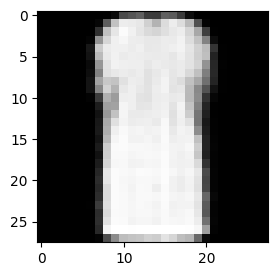

Generated image is Dress


In [ ]:
def test_model(size=3000):
  trained_vae = torch.load(f'/content/drive/MyDrive/Colab Notebooks/model/vae_model_w_{size}_samples.pth')
  trained_vae.eval()

  latent_dim = 50
  random_latent_vector = torch.randn(1, latent_dim).to(device)

  with torch.no_grad():  # No need to calculate gradients during image generation
      generated_image = trained_vae.decode(random_latent_vector)

  generated_image = generated_image.cpu().numpy().reshape(28,28)  # Move to CPU and reshape
  display_image(generated_image)  # Use your display_image function from earlier


  map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
  }

  trained_svm = joblib.load(f'/content/drive/MyDrive/Colab Notebooks/model/svm_model_{size}_rbf.pkl')
  res = trained_svm.predict(random_latent_vector.cpu())
  print(f'Generated image is {map[res.item()]}')

# Test out VAE model and SVM classifier
test_model()